In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import math

In [36]:
class SpatialPooler:
    def __init__(self, input_size, w=10, h=10, conPerm=.5, minOver=5):
        self.input_size = input_size                # input vector 크기
        self.input_data = np.empty([self.input_size])
        self.column_w = w                           # column 의 가로 크기
        self.column_h = h                           # column 의 세로 크기
        self.connectedPerm = conPerm                     # synapse 활성화(1) 될 permanence 임계치
        self.min_overlap = minOver # 발화 하기 위한 컬럼 당 최소한의 overlap count
        self.minGlobalActivity = 0                  # 승리하기 위해 필요한 score (global inhibition)
        self.desiredGlobalActivity = int(0.05 * self.column_w * self.column_h) # 한 번에 승리할 column 수 (global inhibition)
        self.minDutyCycle = 0                       # column 당 최소 발화 duty
        self.highDutyCycle = 0
        self.permanence_inc = .01                   # 학습시 permanence 증가량
        self.permanence_dec = .01                   # 학습시 permanence 감소량
        self.history_capacity = 50
        self.step = 0                               # 데이터 처리한 수
        
        self.columns2D = np.random.rand(self.column_w, self.input_size, self.column_h) # permanence ndarry. 초기화 필요      
        self.columns2D_avail = np.zeros([self.column_w, self.input_size, self.column_h]) # 모든 셀들의 연결 유무 정보
        self.boosts2D = np.ones([self.column_w, self.column_h])                    # 보정에 필요한 boost 
        self.overlapped = np.zeros([self.column_w, self.column_h])                 # input 과 연결된 synapse 들과의 최초 계산
        self.activeColumns = np.zeros([self.column_w, self.column_h])
        self.activeHistory = []                                                    # active duty 를 계산하기 위한 active 기록
        self.overlapHistory = []                                                   # overlap duty 를 계산하기 위한 overlap 기록
        self.activeDutyInfo = np.zeros([self.column_w, self.column_h])             # active duty 정보
        self.overlapDutyInfo = np.zeros([self.column_w, self.column_h])            # overlap duty 정보
        
        ## duty 계산을 위한 history 생성 ##
        for w in range(self.column_w):
            self.activeHistory.append([])
            self.overlapHistory.append([])
            
            for h in range(self.column_h):
                self.activeHistory[w].append(collections.deque())
                self.overlapHistory[w].append(collections.deque())
                
    ''' SDR 생성 '''
    def compute_SDR(self, input_data):
        
        self.input_data = input_data
        
        ## 1. overlaping ##
        '''
        for w in range(self.column_w):
            for h in range(self.column_h):
                for s in range(self.input_size):
                    if(self.columns2D[w][s][h] > self.connectedPerm):
                        self.columns2D_avail[w][s][h] = 1
                    else:
                        self.columns2D_avail[w][s][h] = 0         
        ''' 
        self.columns2D_avail = self.columns2D > self.connectedPerm
        
        self.overlapped = self.input_data @ self.columns2D_avail
        #print(self.overlapped)
        
        for w in range(self.column_w):
            for h in range(self.column_h):
                if(self.overlapped[w][h] > self.min_overlap):
                    self.overlapped[w][h] *= self.boosts2D[w][h]
                    
                    if(len(self.overlapHistory[w][h]) >= self.history_capacity):
                        self.overlapHistory[w][h].popleft()
                        
                    self.overlapHistory[w][h].append(True)
                    
                else:
                    self.overlapped[w][h] = 0
                    
                    if(len(self.overlapHistory[w][h]) >= self.history_capacity):
                        self.overlapHistory[w][h].popleft()
                        
                    self.overlapHistory[w][h].append(False)
                    
                    
        ## 2. inhibition (global) ##
        
        self.minGlobalActivity = self.kthScore(self.desiredGlobalActivity)
        self.activeColumns = self.overlapped > self.minGlobalActivity
        
        for w in range(self.column_w):
            for h in range(self.column_h):
                
                if(len(self.activeHistory[w][h]) >= self.history_capacity):
                    self.activeHistory[w][h].popleft()
                    
                self.activeHistory[w][h].append(self.activeColumns[w][h])
                    
        '''
        for w in range(self.column_w):
            for h in range(self.column_h):
                #print("min :", self.minLocalActivity)
                
                if(self.overlapped[w][h] > self.minGlobalActivity and (w, h) not in self.activeColumns):
                    self.activeColumns.append((w, h))
                    
                    if(len(self.activeHistory[w][h]) > 100):
                        self.activeHistory[w][h].popleft()
                        
                    self.activeHistory[w][h].append(True)
                    
                else:
                    if(len(self.activeHistory[w][h]) > 100):
                        self.activeHistory[w][h].popleft()
                        
                    self.activeHistory[w][h].append(False)
        
                    
        for w in range(self.column_w):
            for h in range(self.column_h):
                self.SDRs[w][h] = 0
        
        for w, h in self.activeColumns:
            self.SDRs[w][h] = 1
        ''' 
                
        ## 3. learning ## 
        for w in range(self.column_w):
            for h in range(self.column_h):
                
                if self.activeColumns[w, h] == 1:
                    for s in range(self.input_size):
                        
                        if(self.columns2D_avail[w][s][h] == 1):
                            if(self.input_data[s] == 1):
                                self.columns2D[w][s][h] += self.permanence_inc
                                self.columns2D[w][s][h] = min(self.columns2D[w][s][h], 1.0)
                            else:
                                self.columns2D[w][s][h] -= self.permanence_dec
                                self.columns2D[w][s][h] = max(self.columns2D[w][s][h], 0.0)
                                            
                    
        ## 3.2. 보정 작업 ##
        self.update_activeDuty()
        self.update_overlapDuty()
        self.step += 1
        
        for w in range(self.column_w):
            for h in range(self.column_h):                    
                ## 자주 승리하지 못하는 column 에 대하여 잘 발화할 수 있도록 boost 시켜줌
                self.minDutyCycle = .1 * self.maxDutyCycle()
                self.highDutyCycle = 5 * self.minDutyCycle
                #print("min :", self.minDutyCycle)
                self.boostFunction(w, h, .01)
                #print(self.boosts2D)

                ## input 과 잘 겹치지 않는 synapse 에 대해서 permanence 증가시켜줌
                if(self.overlapDutyInfo[w][h] < self.minDutyCycle):
                    self.increase_Permanence(w, h)
                    #print("min", self.minDutyCycle)
                        
                        
    ''' global 하게 승리할 컬럼의 기준 '''
    def kthScore(self, desired_kth):
        
        rank = self.overlapped.ravel().copy()
        rank.sort()        
        score = rank[-desired_kth]
        
        return score
    
    
    ''' global 하게 가장 자주 승리한 컬럼의 duty '''
    def maxDutyCycle(self):
        
        rank = self.activeDutyInfo.ravel().copy()
        rank.sort()
        maxDuty = rank[-1]
        
        return maxDuty
    
    
    ''' 해당 column 이 발화하도록 격려 '''
    def boostFunction(self, w, h, boost):
        if(self.activeDutyInfo[w][h] <= self.minDutyCycle):
            self.boosts2D[w][h] += boost
        elif(self.activeDutyInfo[w][h] > self.highDutyCycle):
            self.boosts2D[w][h] -= boost
            
            
    ''' 해당 column 의 모든 셀의 synapse 의 permanence 를 증가시켜 잘 겹치도록 격려 '''
    def increase_Permanence(self, w, h):
        self.columns2D[w, :, h] += self.permanence_inc
        
        
    ''' activeDuty update '''
    def update_activeDuty(self):
        for w in range(self.column_w):
            for h in range(self.column_h):
                self.activeDutyInfo[w][h] = np.sum(self.activeHistory[w][h]) / self.history_capacity

                
    ''' overlapDuty update '''
    def update_overlapDuty(self):
        for w in range(self.column_w):
            for h in range(self.column_h):
                self.overlapDutyInfo[w][h] = np.sum(self.overlapHistory[w][h]) / self.history_capacity
    
    def visualize_SDR(self):
        #plt.imshow(self.activeColumns)
        #plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        #cax = plt.axes([0.85, 0.1, 0.075, 0.8])
        #plt.colorbar(cax=cax)
        #plt.show()
        
        sparsity = (np.count_nonzero(self.activeColumns==True)/(self.column_w*self.column_h))
        return sparsity

boost : 
 [[2.77 3.42 3.21 3.12 2.9  2.77 2.83 3.36 2.71 3.35 3.3  3.15 3.24 3.48
  3.11 3.31 3.47 3.37 3.03 3.34 3.3  3.18 2.88 3.26 3.05 3.26 3.43 2.82
  3.09 3.29 3.27 3.32]
 [3.33 3.38 3.29 3.41 3.38 3.44 3.4  3.54 3.24 3.31 3.35 3.34 3.37 3.27
  3.42 2.6  3.02 3.43 2.72 3.37 3.22 3.29 3.08 3.41 3.13 3.33 3.13 3.33
  3.08 2.7  2.71 3.26]
 [3.28 3.07 3.38 2.69 2.68 3.18 2.75 3.24 3.38 3.36 2.91 2.63 3.48 3.53
  3.34 3.45 3.14 3.3  3.42 3.36 3.39 3.2  2.73 3.45 3.12 3.4  3.34 3.25
  2.82 3.19 2.9  3.32]
 [3.39 3.29 3.2  3.41 3.19 2.7  3.32 3.41 2.95 3.34 3.41 3.07 3.37 3.33
  2.66 3.33 3.33 3.41 3.19 3.28 3.08 3.41 3.31 3.37 3.31 3.33 3.3  2.78
  3.42 2.63 3.34 2.7 ]
 [2.96 3.19 3.23 3.35 3.15 3.31 3.35 3.18 2.81 3.32 2.66 2.58 3.47 3.33
  3.37 2.74 3.31 2.78 3.11 3.12 2.74 3.3  3.46 2.65 3.47 3.1  3.29 3.37
  3.49 2.95 3.4  3.38]
 [3.37 3.28 3.3  3.25 3.34 3.37 3.31 3.34 3.08 3.23 3.54 3.35 3.4  3.49
  3.24 3.43 2.8  3.24 3.16 3.27 3.12 2.81 3.26 2.95 3.18 3.36 3.43 3.07
  3.19 3.55

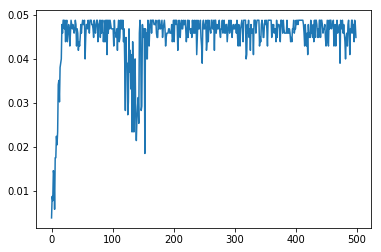

In [113]:
#-- 1. sort 1열로 됨?
#-- 2. 행렬 곱 테스트 3d array
#-- 3. KthScore 정렬 잘 될까
# 4. 학습과 보정이 잘 진행되는지 확인
# 5. 제대로 된 data 주입해보기
# 같은 데이터를 집어넣으니까 보정 작업에서 발산한다.
# 그것보다 duty 계산 보정을 해야한다.
# 6. activeDuty 보수하기

import random

np.set_printoptions(threshold=np.nan)

sp = SpatialPooler(10,32,32,.8,3)
        
step = 500
on_cnt = 5
rand_data = np.zeros([10])

y=np.empty([step])

for s in range(step):
    rand_data = np.zeros([10])
    
    for i in range(on_cnt):
        idx = random.randint(0,9)
        
        while(True):
            if(rand_data[idx] == 1):
                idx = random.randint(0,9)
            else:
                break
                
        rand_data[idx] = 1
        
    sp.compute_SDR(rand_data)
    y[s] = sp.visualize_SDR()
    #y.append(sp.visualize_SDR())
    
plt.plot(range(step), y)

print("boost : \n", sp.boosts2D)
print("active : \n", sp.activeDutyInfo)
print("overlap : \n", sp.overlapDutyInfo)

print("-"*50)
print("\n")
print("sparsity 평균 : {}, 표준편차 : {}\n".format(np.mean(y), np.std(y)))
print("activeDuty 평균 : {}, 표준편차 : {}\n".format(np.mean(sp.activeDutyInfo), np.std(sp.activeDutyInfo)))
print("overlap 평균 : {}, 표준편차 : {}\n".format(np.mean(sp.overlapDutyInfo), np.std(sp.overlapDutyInfo)))

In [111]:
step = 10
on_cnt = 5
rand_data = np.zeros([10])

y=np.empty([step])

for s in range(step):
    rand_data = np.zeros([10])
    for i in range(on_cnt):
        idx = random.randint(0,9)
        
        while(True):
            if(rand_data[idx] == 1):
                idx = random.randint(0,9)
            else:
                break
                
        rand_data[idx] = 1
    print(rand_data)

[0. 0. 0. 0. 1. 1. 1. 1. 1. 0.]
[0. 0. 1. 0. 0. 0. 1. 1. 1. 1.]
[1. 0. 1. 0. 1. 0. 0. 0. 1. 1.]
[1. 0. 0. 1. 0. 1. 1. 1. 0. 0.]
[1. 1. 0. 1. 0. 0. 0. 1. 1. 0.]
[0. 1. 0. 1. 1. 1. 1. 0. 0. 0.]
[0. 1. 1. 0. 0. 1. 0. 1. 1. 0.]
[0. 1. 1. 0. 1. 0. 1. 0. 0. 1.]
[0. 0. 1. 1. 1. 0. 0. 1. 0. 1.]
[0. 0. 0. 1. 1. 1. 0. 0. 1. 1.]
